# 风险溢价

## 加载模块

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
from numpy.lib.stride_tricks import as_strided as stride

## 读入文件

In [2]:
df_merge = pd.read_csv('../data/stock-accounting.csv')
df_merge['date'] = pd.to_datetime(df_merge['date'])

## Fama-MacBeth 回归

剔除 `nan` 数据

In [3]:
idx_fac = ['beta', 'market-cap', 'book-to-market', 'profit', 'investment', 'past-return']
par = ['const'] + idx_fac
df_fit = df_merge[['date', 'stg', 'RET-RF'] + idx_fac].copy()
df_fit = df_fit.replace([np.inf, -np.inf], np.nan)
df_fit = df_fit.dropna()
df_fit.shape[0]

1012235

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1460.
Date:                Sat, 14 Jun 2025   Prob (F-statistic):               0.00
Time:                        12:38:12   Log-Likelihood:             2.7094e+05
No. Observations:             1012235   AIC:                        -5.419e+05
Df Residuals:                 1012228   BIC:                        -5.418e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0094      0.000     50.

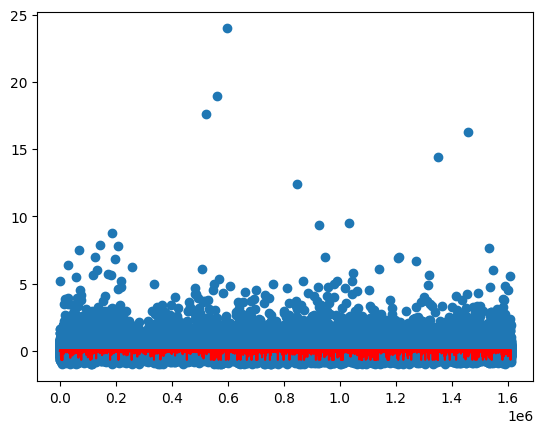

In [4]:
# x = df_fit.loc[df_fit['stg'] == 'Mature', idx_fac]
x = df_fit[idx_fac]
z = pd.DataFrame(index=x.index, columns=idx_fac)
for fac in idx_fac:
    z[fac] = (x[fac] - x[fac].mean()) / x[fac].std()
    z.loc[z[fac] > 3, fac] = 3
    z.loc[z[fac] < -3, fac] = 3
z = sm.add_constant(z)
# y = df_fit.loc[df_fit['stg'] == 'Mature', 'RET-RF']
y = df_fit['RET-RF']
result = sm.OLS(y, z).fit()
print(result.summary())
print(result.params * 100)
y_pred = result.predict(z)
plt.scatter(z.index, y)
plt.plot(z.index, y_pred, color='red')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.674
Date:                Sat, 14 Jun 2025   Prob (F-statistic):            0.00137
Time:                        12:38:14   Log-Likelihood:                 397.31
No. Observations:                 584   AIC:                            -780.6
Df Residuals:                     577   BIC:                            -750.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0499      0.005      9.

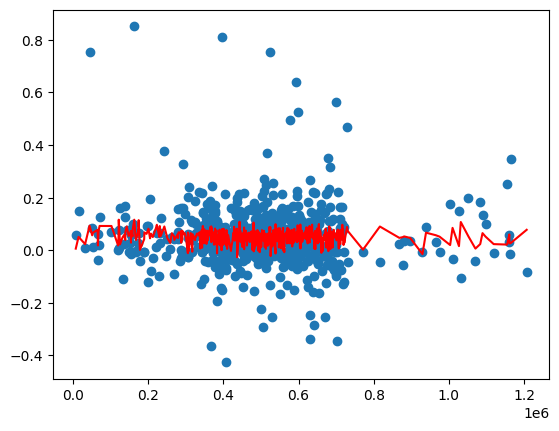

const             0.688692
beta              0.061842
market-cap        0.292097
book-to-market     -3.4362
profit           -0.657728
investment       -0.521756
past-return      -0.511415
dtype: object
const             2.330787
beta              0.345652
market-cap        2.774451
book-to-market   -19.52765
profit           -4.651279
investment       -5.547192
past-return      -5.456693
dtype: object


In [5]:
time_series = df_merge['date'].unique()
time_series = np.sort(time_series)

df_params = pd.DataFrame(columns=['date'] + par)

for i, t in enumerate(time_series):
    df_date = df_fit[(df_fit['date'] == t) & (df_fit['stg'] == 'Growth')]
    x = df_date[idx_fac]
    z = (x - x.mean()) / x.std()
    z[z > 3] = 3
    z[z < -3] = 3
    z = sm.add_constant(z)
    y = df_date[['RET-RF']]
    result = sm.OLS(y, z).fit()
    df_params.loc[i, 'date'] = t
    df_params.loc[i, z.columns] = result.params

    if i == 0:
        print(result.summary())
        y_pred = result.predict(z)
        plt.scatter(z.index, y)
        plt.plot(z.index, y_pred, color='red')
        plt.show()

print(df_params[par].mean() * 100)
print(np.sqrt(408) * df_params[par].mean() / df_params[par].std())

## 风险溢价估计

## 多空投资组合

## 滚动窗口估值

## EXHIBIT 9